In [1]:
# the purpose of this notebook is to test and time alternative lung masking techniques
import os                                   # do directory ops
import math                                 # used for ceil ops
import datetime                             # used for saving with a datetime string
import pandas as pd                         # data analysis
import numpy as np                          # array ops
import matplotlib.pyplot as plt             # used for visualization in dev
import pydicom                              # for reading dicom files
from cv2 import resize, threshold, THRESH_OTSU           # image processing
from skimage import morphology, measure     # for lung masking
from skimage.transform import rescale, resize
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans          # for lung masking
from tqdm import tqdm                       # for progress bars
import seaborn as sns
import cv2
from importlib import reload

import sys
# import current lungmask technique
sys.path.insert(1, '/Users/jesse/Documents/osic_kaggle/scripts/submission_scripts')
import pre_proc
from random import choice

In [2]:
# new method using otsu's thresholding
def make_lungmask_v2(img):

    mid_dict = {}

    row_size= img.shape[0]
    col_size = img.shape[1]

    # Rescale pixels to 255
    img = img.astype(float)
    #### need to get middle portion and normalize to it
    # Find the average pixel value near the lungs to renormalize washed out images.
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    im_mean = np.mean(middle)  
    im_max = np.max(img)
    im_min = np.min(img)
    # To improve threshold finding, I'm moving the underflow and overflow on the pixel spectrum
    img[img==im_max]=im_mean
    img[img==im_min]=im_mean

    im_min = np.min(img) # many are not windowed and have vals < 0
    if im_min < 0:
        img = img - im_min
    img = (np.maximum(img,0) / img.max()) * 255.0

    # EXPERIMENTAL
    img = gaussian_filter(img, sigma=1)

    # otsu's binarization thresholding
    thresh, thresh_img = threshold(img.astype('uint8'), np.min(img), np.max(img), THRESH_OTSU)
    # rescale to binary and invert
    thresh_img = np.where(thresh_img==0,1,0)

    mid_dict['thresholded'] = thresh_img

    ###########################################

    # now copy functionality from the old method to achieve a mask

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    erosion = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(erosion,np.ones([13,13]))

    mid_dict['morph'] = dilation

    labels = measure.label(dilation) # Different labels are displayed in different colors
    labels = labels + 1 # add 1 to every element so that the background is no longer encoded as 0
    regions = measure.regionprops(labels) # for some reason ignores labels marked 0
    good_labels = []
    n_px = len(img.flatten())
    for prop in regions:
        B = prop.bbox # (min_row, min_col, max_row, max_col)
        # region width < 90% of img
        # region height < 90% of img
        # min row > 15%, max row < 85%
        # min col < 15%, max col < 85%
        # region area is > 0.1% of img
        if B[2]-B[0]<row_size*.80 and \
            B[3]-B[1]<col_size*.80 and \
            B[0]>row_size*.05 and B[2]<row_size*.95 and \
            B[1]>col_size*.05 and B[3]<col_size*.95 and \
            prop.area/n_px*100 > 0.1:
            good_labels.append(prop.label) 
            #print(f'prop {prop.label} area: {np.round(prop.area/n_px*100,2)}, {B}')
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([5,5])) # one last dilation

    # final masked image
    masked_img = mask*img
    mask_var = np.round(np.var(mask), 4)
    n_labels = len(good_labels)

    return masked_img, mask_var, n_labels, mid_dict

### List of patient: problem
- (512, 512) looks good
- (768, 768) looks good
- (1100, 888) looks good
- (1302, 1302) looks good
- (733, 888) looks good
- (734, 888) looks good
- (752, 888) looks good
- (788, 888) looks good
- (843, 888) looks good


In [5]:
# patient images may be different according to dimensions!
meta_data_df = pd.read_csv('/Users/jesse/Documents/osic_kaggle/data/processed_data/meta_data_df.csv')
meta_data_df['dims'] = (meta_data_df['rows'].astype(str) + ', ' + meta_data_df['columns'].astype(str))
display(meta_data_df.groupby(['dims'])['Patient'].nunique())
patients_dims = meta_data_df.groupby(['dims'])['Patient'].unique()

dims
1100, 888       1
1302, 1302      1
512, 512      131
632, 632        2
733, 888        1
734, 888        1
752, 888        2
768, 768       32
788, 888        1
843, 888        1
Name: Patient, dtype: int64

In [186]:
# prepare random patient folder of images for processing
dicom_dir = "/Users/jesse/Documents/osic_kaggle/data/train/"
patients = os.listdir(dicom_dir) # list of training patient IDS (folders which contain DICOMS)
# patient = choice(patients)
# patient = 'ID00032637202181710233084'

patient = choice(patients_dims['512, 512'])

path = dicom_dir + patient
dicoms = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
dicoms.sort(key=lambda x: int(x.ImagePositionPatient[2]))

print(f'Patient: {patient}; n CTs: {len(dicoms)}')

Patient: ID00279637202272164826258; n CTs: 30


In [187]:
%%time

reload(pre_proc)

slices = []
manually_thresholded_slices = []

for dicom in tqdm(dicoms):

    # grab information from dicoms for later
    img = dicom.pixel_array.copy()
    rescale_intercept = dicom.RescaleIntercept
    rescale_slope = dicom.RescaleSlope

    # remove border if there is one
    img = pre_proc.custom_trim(img)

    # rescale HU
    hu_scaled_img = pre_proc.transform_to_hu(img=img, rescale_slope=rescale_slope, rescale_intercept=rescale_intercept)
    # window
    windowed_img = pre_proc.set_manual_window(hu_scaled_img)
    # mask slice
    masked_img = pre_proc.lung_mask(windowed_img) # A LOT OF JUNK IN A TUPLE. FIRST ITEM IS ACTUAL MASKED IM
    
    slices.append(masked_img[0])
    manually_thresholded_slices.append(masked_img[1])

100%|██████████| 30/30 [00:01<00:00, 20.74it/s]CPU times: user 1.42 s, sys: 37.5 ms, total: 1.46 s
Wall time: 1.46 s



15


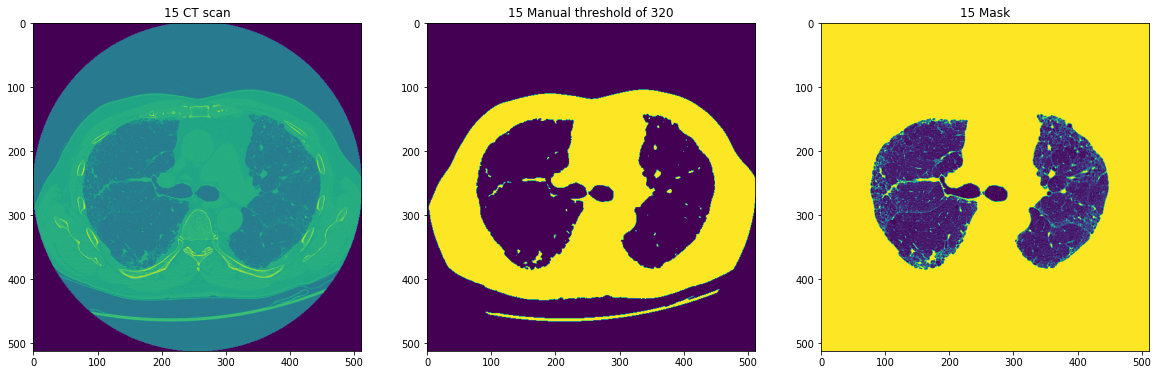

In [188]:
i = len(slices)//2
print(i)
# i = 11

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,40))
ax[0].imshow(dicoms[i].pixel_array);
ax[0].set_title(f'{i} CT scan');
ax[1].imshow(manually_thresholded_slices[i]);
ax[1].set_title(f'{i} Manual threshold of 320');
ax[-1].imshow(slices[i]);
ax[-1].set_title(f'{i} Mask');

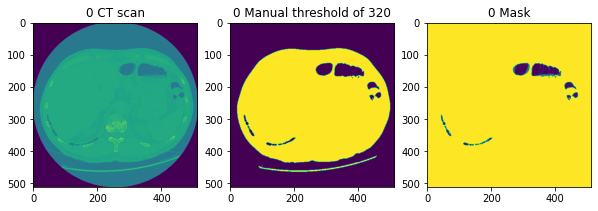

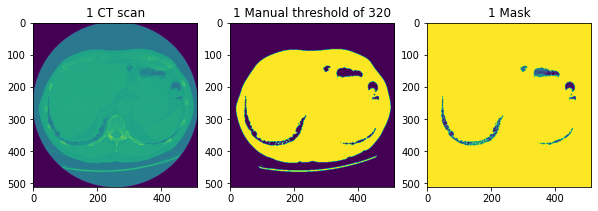

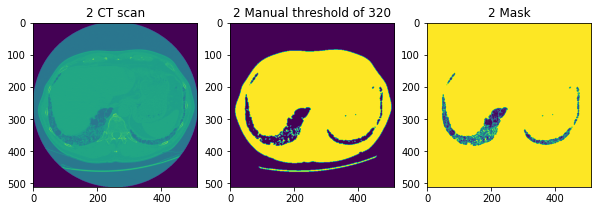

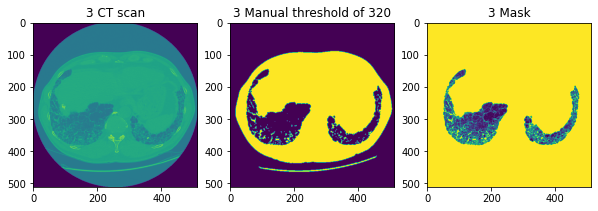

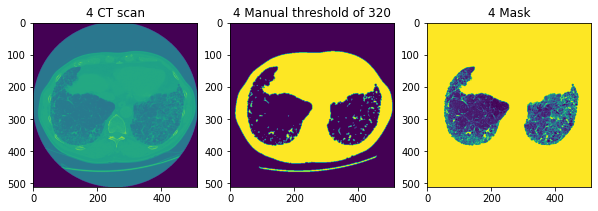

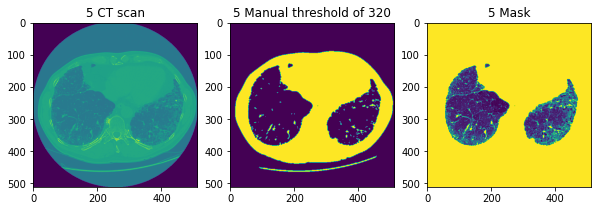

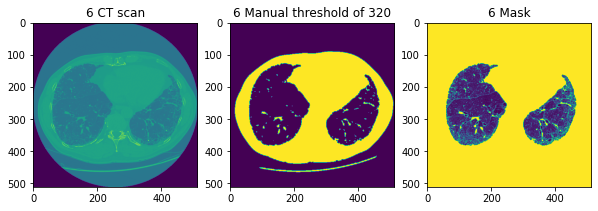

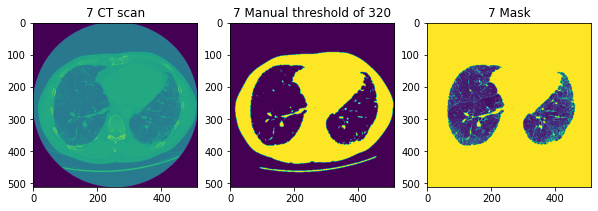

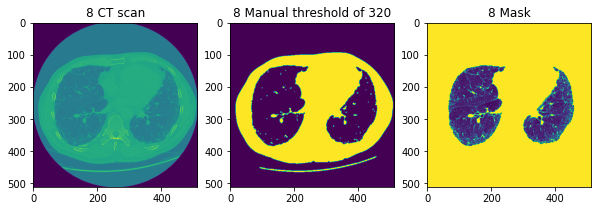

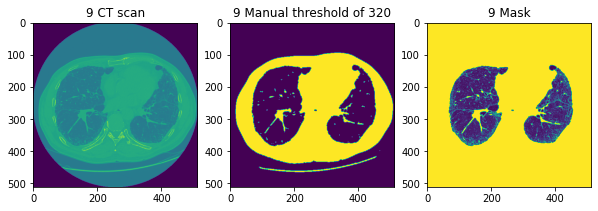

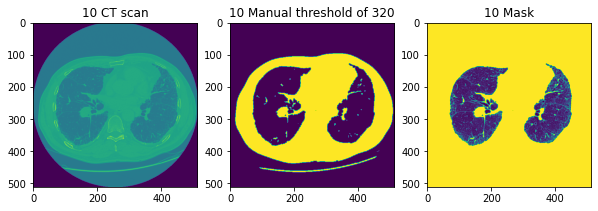

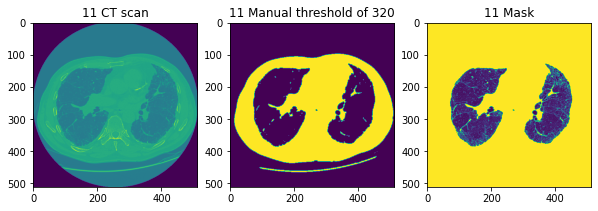

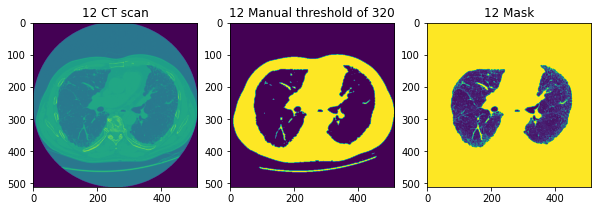

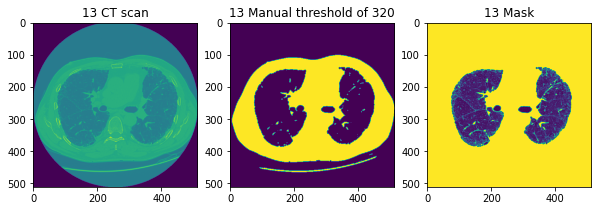

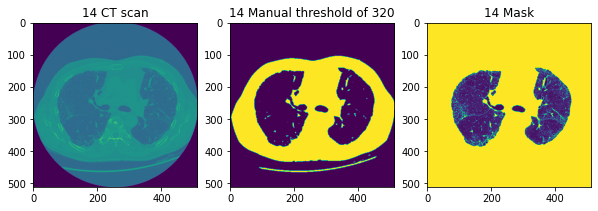

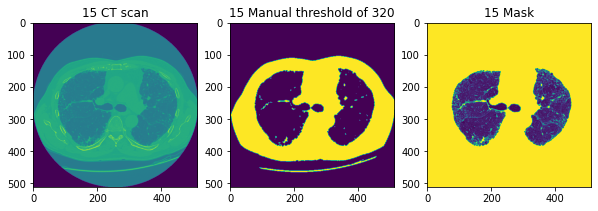

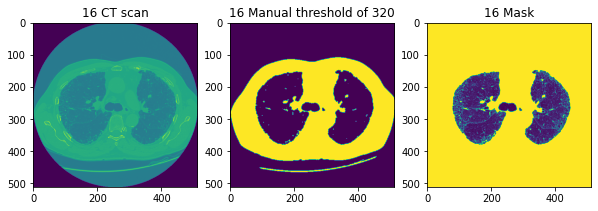

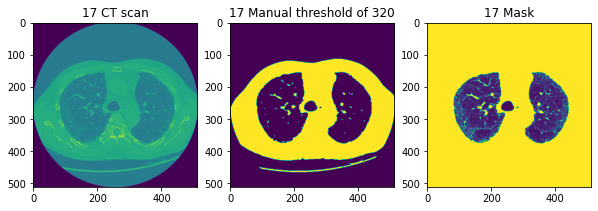

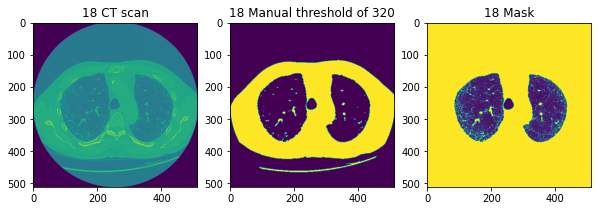

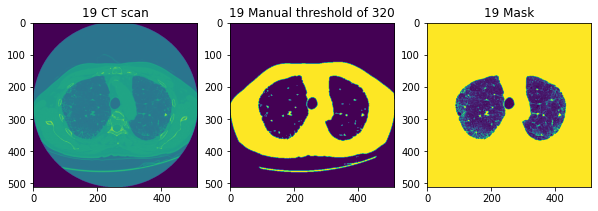

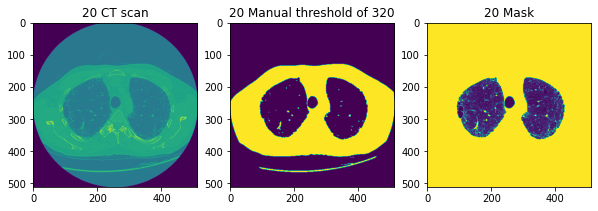

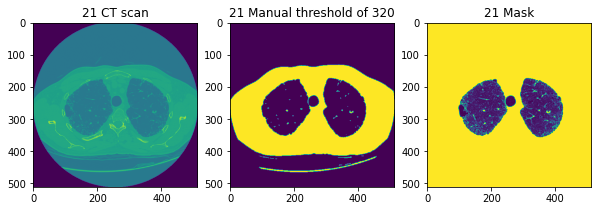

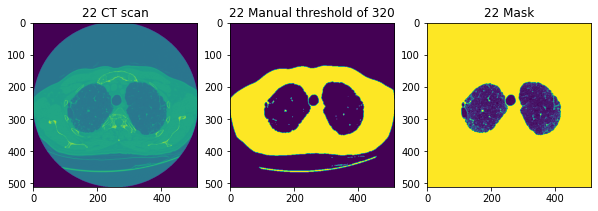

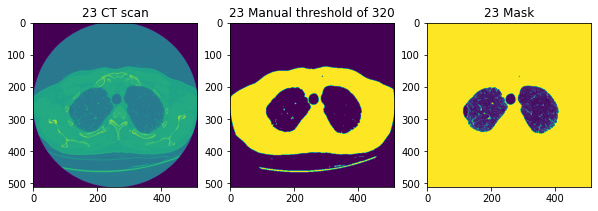

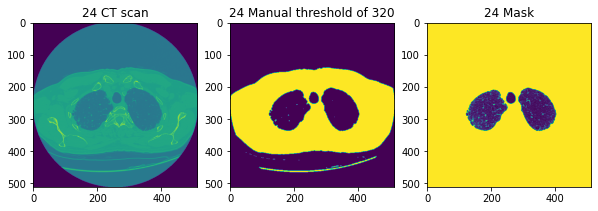

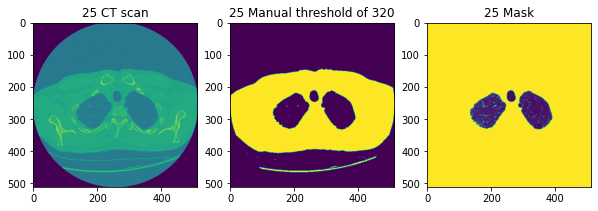

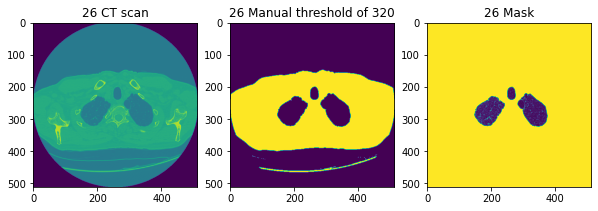

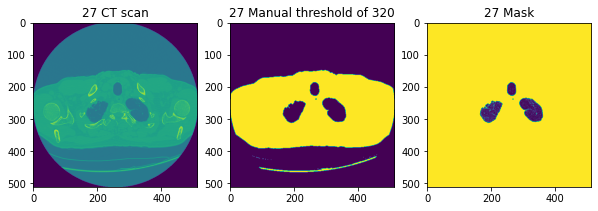

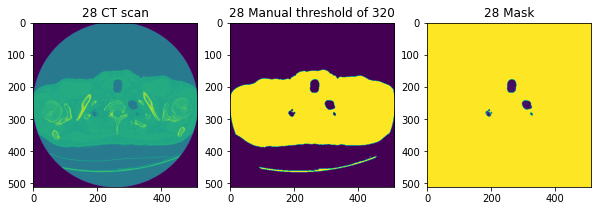

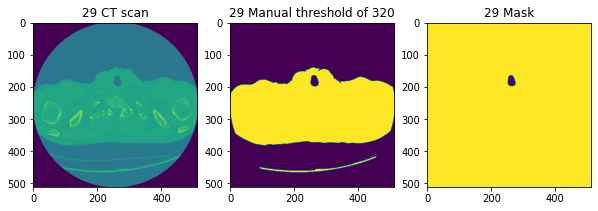

In [189]:
# View patient scan masks

for i in range(0, 30, 1):
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,30))
    ax[0].imshow(dicoms[i].pixel_array);
    ax[0].set_title(f'{i} CT scan');
    ax[1].imshow(manually_thresholded_slices[i]);
    ax[1].set_title(f'{i} Manual threshold of 320');
    ax[-1].imshow(slices[i]);
    ax[-1].set_title(f'{i} Mask');
    plt.show()

187 700 806 293


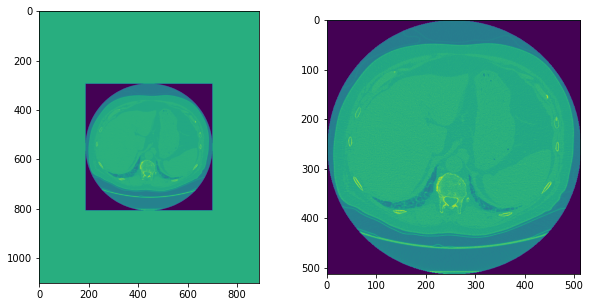

In [147]:
reload(pre_proc)
img = dicoms[0].pixel_array.copy()
cropped_img = pre_proc.custom_trim(img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(img);
ax[1].imshow(cropped_img);

In [ ]:
# deep dive cell
imgs = []
titles = []
i = 37

reload(pre_proc)

img = dicoms[i].pixel_array.copy()
imgs.append(img), titles.append('DICOM')

rescale_intercept = dicoms[i].RescaleIntercept
rescale_slope = dicoms[i].RescaleSlope

cropped_img = pre_proc.custom_trim(img)
imgs.append(cropped_img), titles.append('CROPPED')

hu_scaled_img = pre_proc.transform_to_hu(img=cropped_img, rescale_slope=rescale_slope, rescale_intercept=rescale_intercept)
imgs.append(hu_scaled_img), titles.append('HU RESCALED')

windowed_img = pre_proc.set_manual_window(hu_scaled_img)
imgs.append(windowed_img), titles.append('WINDOWED')

masked_img, manually_thresholded, manually_filled, binary_labels, pre_experimental = pre_proc.lung_mask(windowed_img)
imgs.append(manually_thresholded), titles.append('MANUALLY THRESHOLDED')
imgs.append(manually_filled), titles.append('MANUALLY FILLED FROM CORNERS')
imgs.append(pre_experimental), titles.append('PRE EXPERIMENTAL')
imgs.append(binary_labels), titles.append('BINARY_LABELS')
imgs.append(masked_img), titles.append('FINAL_MASK')

fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(30, 10))
for ind, im in enumerate(imgs):
    ax[ind].imshow(im);
    ax[ind].set_title(titles[ind]);